In [13]:
%reset -f
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
mpl.rc('axes', labelsize=20)
mpl.rc('xtick', labelsize=15)
mpl.rc('ytick', labelsize=15)
dpi=320
# mpl.rc('title', fontsize=30)
from joblib import load
import numpy as np
import tensorflow as tf
from modules.param_wgan_gp import WGAN
from json import load as jload
try:
    # Disable all GPUS
    tf.config.set_visible_devices([], 'GPU')
    visible_devices = tf.config.get_visible_devices()
    for device in visible_devices:
        assert device.device_type != 'GPU'
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
print(tf.config.get_visible_devices())

mname, epoch = "old1", 90
with open(f"models/{mname}/model_params.json") as ff:
    param_dict = jload(ff)
old1 = WGAN(**param_dict)
old1.gen.load_weights(f"models/{mname}/epoch{epoch}/generator_weights.h5")
old1.dis.load_weights(f"models/{mname}/epoch{epoch}/discriminator_weights.h5")

mname, epoch = "old2", 20
with open(f"models/{mname}/model_params.json") as ff:
    param_dict = jload(ff)
old2 = WGAN(**param_dict)
old2.gen.load_weights(f"models/{mname}/epoch{epoch}/generator_weights.h5")
old2.dis.load_weights(f"models/{mname}/epoch{epoch}/discriminator_weights.h5")

mname = "gLN"
with open(f"model_params_{mname}.json") as ff:
    param_dict = jload(ff)
gLN = WGAN(**param_dict)
gLN.gen.load_weights(f"generator_weights_{mname}.h5")
gLN.dis.load_weights(f"discriminator_weights_{mname}.h5")


train = np.load(param_dict['train_set'], allow_pickle=True)
sclr = load(param_dict['scaler'])
feature_names = param_dict['feat_names']
print(train.shape)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
(1000000, 19)


In [14]:
true = sclr.inverse_transform(train)
n_samples = train.shape[0] #100000
p_old1 = sclr.inverse_transform(old1.gen.predict(tf.random.normal(shape=(n_samples, 128))))
p_old2 = sclr.inverse_transform(old2.gen.predict(tf.random.normal(shape=(n_samples, 64))))
p_gLN = sclr.inverse_transform(gLN.gen.predict(tf.random.normal(shape=(n_samples, 128))))

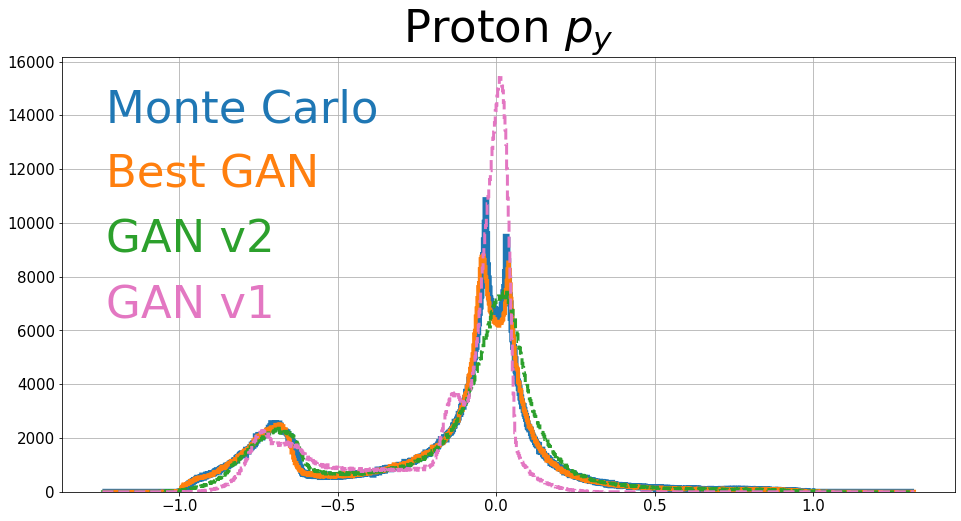

In [34]:
f, ax = plt.subplots(1, 1, figsize=(16,8));# f.tight_layout()
bc = 1000

# ax.set_yscale('log')
ax.set_title(r"Proton $p_y$", fontsize=45)
ax.grid()
# ax.set_yscale('log')
bins = np.linspace(np.min(np.r_[true[:,12],p_old1[:,12],p_old2[:,12],p_gLN[:,12]]), np.max(np.r_[true[:,12],p_old1[:,12],p_old2[:,12],p_gLN[:,12]]), bc+1)
ax.hist(true[:,12], bins=bins, histtype="step", linewidth=6, label="MC")
ax.hist(p_gLN[:,12], bins=bins, histtype="step", linewidth=4, label="GAN")
ax.hist(p_old1[:,12], bins=bins, histtype="step", linewidth=3, linestyle="--", label="OLD1")
ax.hist(p_old2[:,12], bins=bins, histtype="step", linewidth=3, linestyle="--", label="OLD2", color="C6")

ax.text(.05, .85, "Monte Carlo", transform=ax.transAxes, fontsize=45, color='C0')
ax.text(.05, .7, "Best GAN", transform=ax.transAxes, fontsize=45, color='C1')
ax.text(.05, .55, "GAN v2", transform=ax.transAxes, fontsize=45, color='C2')
ax.text(.05, .40, "GAN v1", transform=ax.transAxes, fontsize=45, color='C6')

f.savefig(f"imgs/proton_py_multi.png", facecolor="white", bbox_inches='tight', dpi=dpi)
